# Traces' spatiotemporal dynamics

author: steeve.laquitaine@epfl.ch

activate npx

In [74]:
import os
import numpy as np 
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from probeinterface.plotting import plot_probe
from probeinterface import (
    generate_multi_columns_probe
    )
import MEAutility as MEA

# set project path
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

data_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/raw/vivo_rat_cortex_marques/c1/c1_npx_raw-001.bin"

In [3]:
# load recording
Recording = si.read_binary(data_path, sampling_frequency=30000, num_chan=384, dtype='int16')

In [30]:
def wire_probe(Recording):

    # reconstruct probe    
    N_CONTACT_PER_COL = 96
    N_COLS = 4

    # get Neuropixels-384 as a model to replicate
    mea_ProbeNeuropix384_2D_params = MEA.return_mea_info("Neuropixels-384")

    # set pitches (y:1 is not intuitive but see [1])
    Y_PITCH = (mea_ProbeNeuropix384_2D_params["pitch"][0],)  # inter-columns
    X_PITCH = (mea_ProbeNeuropix384_2D_params["pitch"][1],)  # inter-row
    STAGGER = mea_ProbeNeuropix384_2D_params["stagger"]

    # create 2D ProbeInterface probe object
    probe = generate_multi_columns_probe(
        num_columns=N_COLS,
        num_contact_per_column=N_CONTACT_PER_COL,
        xpitch=X_PITCH,
        ypitch=Y_PITCH,
        y_shift_per_column=[0, STAGGER, 0, STAGGER],
        contact_shapes=mea_ProbeNeuropix384_2D_params["shape"],
        contact_shape_params={"width": mea_ProbeNeuropix384_2D_params["size"]},
    )

    # make 3D
    probe = probe.to_3d(axes="yz")

    # set the contact ids and channel ids to start from 0
    # create Marques site - mapping
    contact_ids = np.vstack([np.arange(0,384,4),
    np.arange(2,384,4),
    np.arange(1,384,4),
    np.arange(3,384,4)]).reshape(1,384).squeeze()

    probe.set_contact_ids(contact_ids)
    probe.set_device_channel_indices(contact_ids)
    return Recording.set_probe(probe)

Recording = wire_probe(Recording)

In [29]:
probe = Recording.get_probe()

In [60]:
# preprocessing
Recording_pre = spre.bandpass_filter(Recording, freq_min=300, freq_max=14999)
Recording_pre = spre.common_reference(Recording_pre, reference='global', operator='median')
traces_pre = Recording_pre.get_traces()

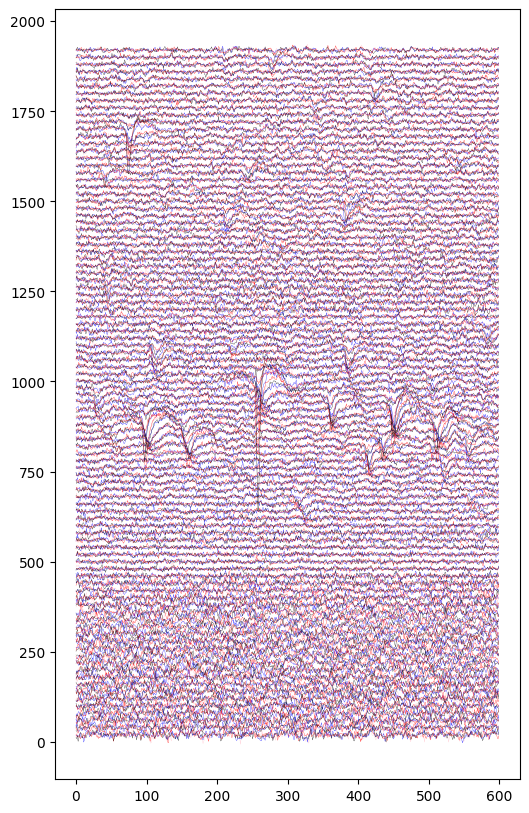

In [75]:
# from 380 (superficial sites near pial) to 0 (deeper sites)
col_1_contact_ids = np.flip(np.arange(0,384,4)) # probe column 1
col_2_contact_ids = np.flip(np.arange(2,384,4)) # probe column 2
col_3_contact_ids = np.flip(np.arange(1,384,4)) # probe column 3
col_4_contact_ids = np.flip(np.arange(3,384,4)) # probe column 4

LINEWIDTH = 0.2
SAMPFREQ = 30000 # Hz
duration = 1000 # ms
period = np.arange(5750, 5750+600, 1) # timepoints

fig, ax = plt.subplots(1,1, figsize=(6,10))
pos_up = 0
for ix in range(len(col_1_contact_ids)):
    pos_up += 20
    plt.plot(traces_pre[period, col_1_contact_ids[ix]] + pos_up, linewidth=LINEWIDTH, color="pink");

pos_up = 0
for ix in range(len(col_2_contact_ids)):
    pos_up += 20
    plt.plot(traces_pre[period, col_2_contact_ids[ix]] + pos_up, linewidth=LINEWIDTH, color="blue");

pos_up = 0
for ix in range(len(col_3_contact_ids)):
    pos_up += 20
    plt.plot(traces_pre[period, col_3_contact_ids[ix]] + pos_up, linewidth=LINEWIDTH, color="red");

pos_up = 0
for ix in range(len(col_4_contact_ids)):
    pos_up += 20
    plt.plot(traces_pre[period, col_4_contact_ids[ix]] + pos_up, linewidth=LINEWIDTH, color="black");

# save figures
plt.savefig("figures/2_realism/1_components/pdf/trace_npx_spacetime_vivo_marques.pdf")
plt.savefig("figures/2_realism/1_components/svg/trace_npx_spacetime_vivo_marques.svg")